<a href="https://colab.research.google.com/github/SVNitinSV/Inventory_projection/blob/main/XGBOOST_025051001_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
from sklearn.metrics import mean_squared_error
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Tek_clover_Inventory_projection/025051001_ML_Outbound_Tek_clover_temporal - Sheet1.csv',index_col='Transaction Date'   ,parse_dates=True,dayfirst=True)
df.head()

,Qty
Transaction Date,
2023-06-27 14:42:54,18
2023-06-29 10:22:06,12
2023-06-29 14:42:16,16
2023-07-04 16:02:13,48
2023-07-04 21:23:03,20


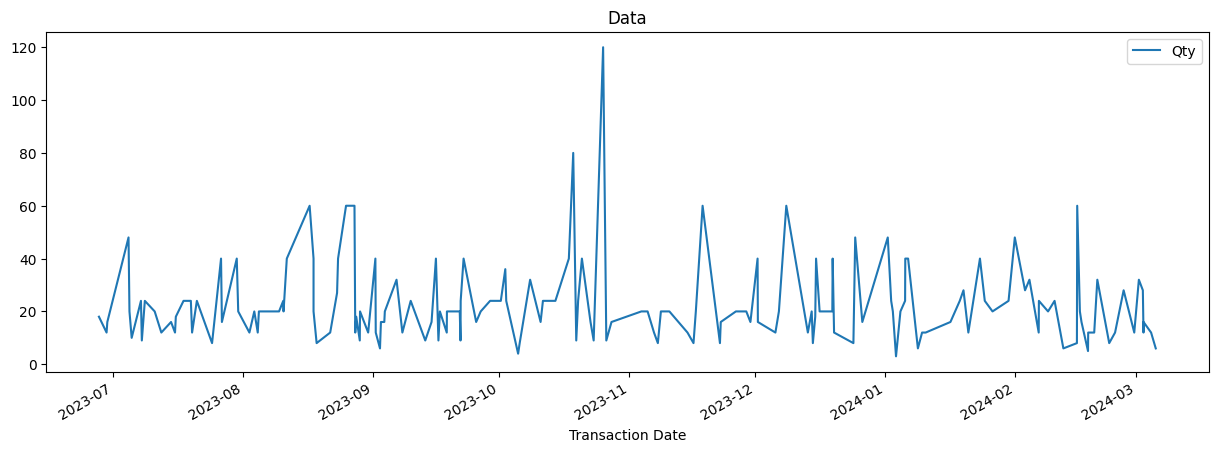

In [ ]:
df.plot(figsize=(15, 5),title='Data')
plt.show()

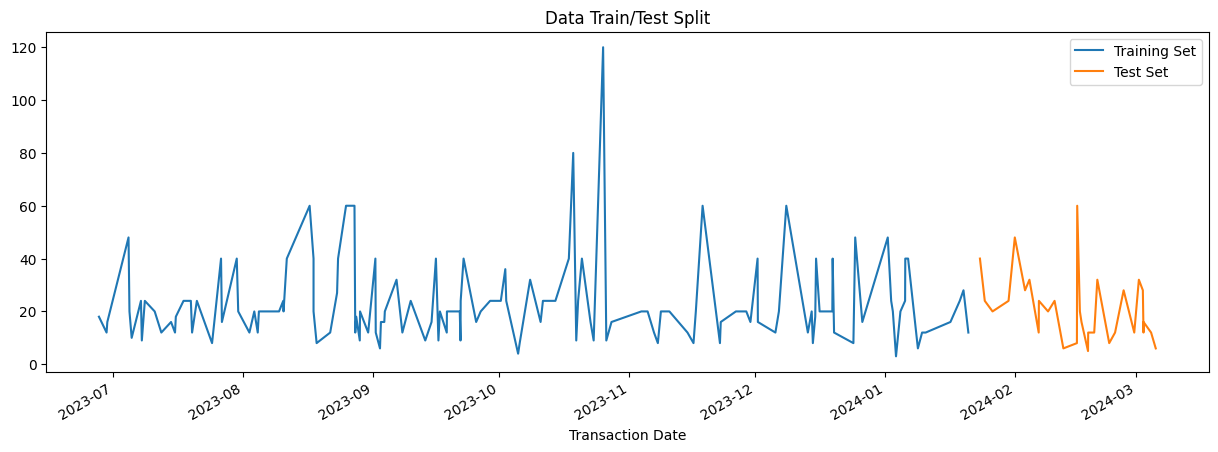

In [ ]:
train=df.iloc[:-30]
test=df.iloc[-30:]

fig, ax = plt.subplots(figsize=(15, 5))
train.plot(ax=ax, label='Training Set', title='Data Train/Test Split')
test.plot(ax=ax, label='Test Set')
ax.legend(['Training Set', 'Test Set'])
plt.show()

In [ ]:
def create_features(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    return df

df = create_features(df)

In [ ]:
train = create_features(train)
test = create_features(test)

FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month', 'year']
TARGET = 'Qty'

X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

In [ ]:
reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',
                       n_estimators=1000,
                       early_stopping_rounds=50,
                       objective='reg:linear',
                       max_depth=3,
                       learning_rate=0.01)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=100)

[0]	validation_0-rmse:27.06187	validation_1-rmse:24.02088
[100]	validation_0-rmse:16.32778	validation_1-rmse:14.49427


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:52:04] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[200]	validation_0-rmse:13.36779	validation_1-rmse:12.77004
[300]	validation_0-rmse:12.45097	validation_1-rmse:12.59760
[375]	validation_0-rmse:11.88165	validation_1-rmse:12.61751


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, objective='reg:linear', ...)

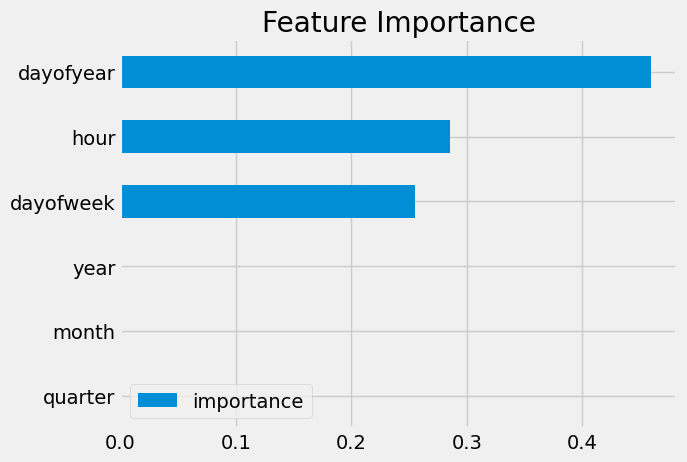

In [ ]:
fi = pd.DataFrame(data=reg.feature_importances_,
             index=reg.feature_names_in_,
             columns=['importance'])
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

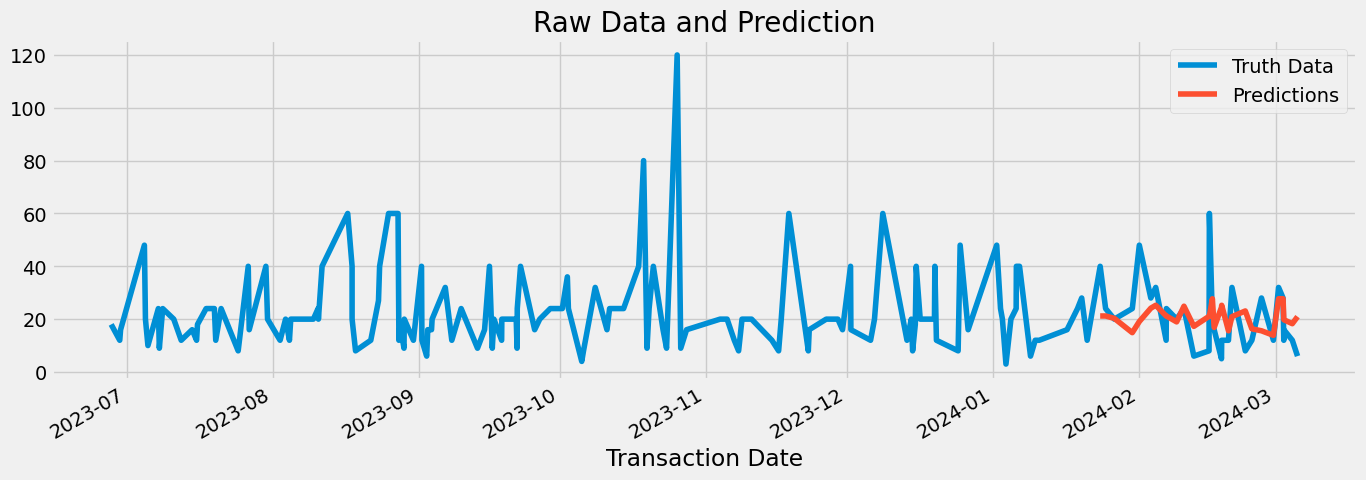

In [ ]:
test['prediction'] = reg.predict(X_test)
df = df.merge(test[['prediction']], how='left', left_index=True, right_index=True)
ax = df[['Qty']].plot(figsize=(15, 5))
df['prediction'].plot(ax=ax)
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Raw Data and Prediction')
plt.show()

In [ ]:
score = np.sqrt(mean_squared_error(test['Qty'], test['prediction']))
print(f'RMSE Score on Test set: {score:0.2f}')

RMSE Score on Test set: 12.60


In [ ]:
test['error'] = np.abs(test[TARGET] - test['prediction'])
test['date'] = test.index.date
test.groupby(['date'])['error'].mean().sort_values(ascending=False).head(10)

date
2024-01-31    28.901287
2024-02-15    26.000000
2024-01-23    18.806412
2024-02-18    16.363515
2024-02-23    15.097229
2024-03-05    14.944038
2024-02-26    12.408035
2024-02-12    11.268538
2024-02-20    11.055962
2024-01-30     9.120192
Name: error, dtype: float64

In [ ]:
df.index.max()

Timestamp('2024-03-05 14:12:36')

In [ ]:
# Create future dataframe
future = pd.date_range('2024-03-06','2024-04-05')
print(future)
future_df = pd.DataFrame(index=future)
future_df['isFuture'] = True
df['isFuture'] = False
df_and_future = pd.concat([df, future_df])
df_and_future = create_features(df_and_future)
df_and_future.tail()

DatetimeIndex(['2024-03-06', '2024-03-07', '2024-03-08', '2024-03-09',
               '2024-03-10', '2024-03-11', '2024-03-12', '2024-03-13',
               '2024-03-14', '2024-03-15', '2024-03-16', '2024-03-17',
               '2024-03-18', '2024-03-19', '2024-03-20', '2024-03-21',
               '2024-03-22', '2024-03-23', '2024-03-24', '2024-03-25',
               '2024-03-26', '2024-03-27', '2024-03-28', '2024-03-29',
               '2024-03-30', '2024-03-31', '2024-04-01', '2024-04-02',
               '2024-04-03', '2024-04-04', '2024-04-05'],
              dtype='datetime64[ns]', freq='D')


,Qty,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,prediction_x,prediction_y,prediction,isFuture
2024-04-01,NaN,0,0,2,4,2024,92,1,14,NaN,NaN,NaN,True
2024-04-02,NaN,0,1,2,4,2024,93,2,14,NaN,NaN,NaN,True
2024-04-03,NaN,0,2,2,4,2024,94,3,14,NaN,NaN,NaN,True
2024-04-04,NaN,0,3,2,4,2024,95,4,14,NaN,NaN,NaN,True
2024-04-05,NaN,0,4,2,4,2024,96,5,14,NaN,NaN,NaN,True


In [ ]:
future_w_features = df_and_future.query('isFuture').copy()
print(future_w_features)

            Qty  hour  dayofweek  quarter  month  year  dayofyear  dayofmonth  \
2024-03-06  NaN     0          2        1      3  2024         66           6   
2024-03-07  NaN     0          3        1      3  2024         67           7   
2024-03-08  NaN     0          4        1      3  2024         68           8   
2024-03-09  NaN     0          5        1      3  2024         69           9   
2024-03-10  NaN     0          6        1      3  2024         70          10   
2024-03-11  NaN     0          0        1      3  2024         71          11   
2024-03-12  NaN     0          1        1      3  2024         72          12   
2024-03-13  NaN     0          2        1      3  2024         73          13   
2024-03-14  NaN     0          3        1      3  2024         74          14   
2024-03-15  NaN     0          4        1      3  2024         75          15   
2024-03-16  NaN     0          5        1      3  2024         76          16   
2024-03-17  NaN     0       

In [ ]:
future_w_features['pred'] = reg.predict(future_w_features[FEATURES])
print(future_w_features)

            Qty  hour  dayofweek  quarter  month  year  dayofyear  dayofmonth  \
2024-03-06  NaN     0          2        1      3  2024         66           6   
2024-03-07  NaN     0          3        1      3  2024         67           7   
2024-03-08  NaN     0          4        1      3  2024         68           8   
2024-03-09  NaN     0          5        1      3  2024         69           9   
2024-03-10  NaN     0          6        1      3  2024         70          10   
2024-03-11  NaN     0          0        1      3  2024         71          11   
2024-03-12  NaN     0          1        1      3  2024         72          12   
2024-03-13  NaN     0          2        1      3  2024         73          13   
2024-03-14  NaN     0          3        1      3  2024         74          14   
2024-03-15  NaN     0          4        1      3  2024         75          15   
2024-03-16  NaN     0          5        1      3  2024         76          16   
2024-03-17  NaN     0       

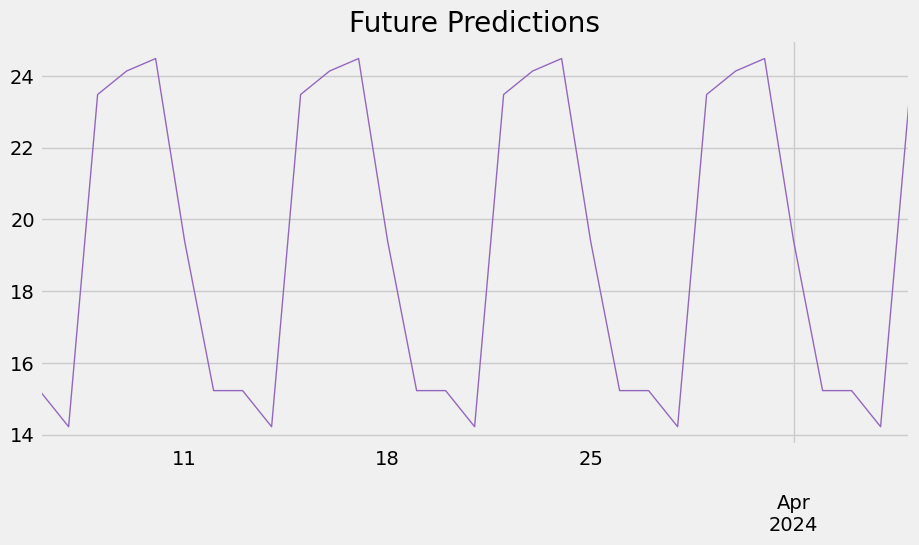

            Qty  hour  dayofweek  quarter  month  year  dayofyear  dayofmonth  \
2024-03-06  NaN     0          2        1      3  2024         66           6   
2024-03-07  NaN     0          3        1      3  2024         67           7   
2024-03-08  NaN     0          4        1      3  2024         68           8   
2024-03-09  NaN     0          5        1      3  2024         69           9   
2024-03-10  NaN     0          6        1      3  2024         70          10   
2024-03-11  NaN     0          0        1      3  2024         71          11   
2024-03-12  NaN     0          1        1      3  2024         72          12   
2024-03-13  NaN     0          2        1      3  2024         73          13   
2024-03-14  NaN     0          3        1      3  2024         74          14   
2024-03-15  NaN     0          4        1      3  2024         75          15   
2024-03-16  NaN     0          5        1      3  2024         76          16   
2024-03-17  NaN     0       

In [ ]:
future_w_features['pred'].plot(figsize=(10, 5),
                               color=color_pal[4],
                               ms=1,
                               lw=1,
                               title='Future Predictions')
plt.show()
print(future_w_features)